In [18]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.applications import InceptionV3, ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation
# from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing import image
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import os, shutil


In [19]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [20]:
path = "./"
fake_images_dir = "../../hard_hats/images/fake_hat_train_images"
train_dataset = "../../hard_hats/images/train"
validation_dateset = "../../hard_hats/images/validation"

In [21]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
])

class ImageClassifier:
    def __init__(self, img_rows, img_cols, channels=3, batch_size=64, directory="./"):
        self.img_shape = (img_rows, img_cols, channels)
        self.batch_size = batch_size
        self.directory = directory
        self.classifier = self.build_classifier()
        self.dataset = self.load_image_dataset()
        self.accuracy = None

    def build_classifier(self):
        base_model = ResNet50(include_top=False, weights='imagenet', input_shape=self.img_shape)
        base_model.trainable = False

        model = Sequential()
        model.add(base_model)
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))
        optimizer = Adam(learning_rate=0.0001)

        model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])

        return model
    
    def load_image_dataset(self, directory="", num_images_per_category=1000, num_no_hat_images=None, include_fake=False,percentage=0.5):
        
        image_data = tf.keras.utils.image_dataset_from_directory(
            directory or self.directory,
            labels='inferred',
            label_mode='binary',
            seed=22,
            image_size=(self.img_shape[0], self.img_shape[1]),
            batch_size=self.batch_size,
        )

        # image_data = image_data.cache()
        fake_image_data = None
        hat_fake_image_data = None  
        if include_fake:
            hat_fake_image_data = tf.keras.utils.image_dataset_from_directory(fake_images_dir, labels='inferred',
            seed=22,image_size=(self.img_shape[0], self.img_shape[1]),batch_size=self.batch_size)
            # hat_fake_image_data = hat_fake_image_data.cache()
            num_no_hat_images = num_images_per_category + int(percentage * num_images_per_category)
            num_images_from_fake = int(percentage * num_images_per_category)

        AUTOTUNE = tf.data.AUTOTUNE
        if num_images_per_category:
            image_data = image_data.unbatch()

            hat = image_data.filter(lambda image, label: tf.reduce_all(tf.equal(label, 0))).take(num_images_per_category)
            no_hat = image_data.filter(lambda image, label: tf.reduce_all(tf.equal(label, 1))).take(num_no_hat_images or num_images_per_category)
                                       
            

            # Take percentage% from hat_fake_image_data
            if include_fake and hat_fake_image_data:
                hat_fake_image_data = hat_fake_image_data.unbatch().take(num_images_from_fake)
                hat = hat.map(lambda image, label: (image, tf.cast(0, tf.int32)))
                hat_fake_image_data = hat_fake_image_data.map(lambda image, label: (image, tf.cast(0, tf.int32)))
                hat = hat.concatenate(hat_fake_image_data)

                no_hat = no_hat.map(lambda image, label: (image, tf.cast(1, tf.int32)))
            combined_images = no_hat.concatenate(hat).shuffle(buffer_size=20000, seed=22)
            combined_images = combined_images.batch(self.batch_size)

            image_data = combined_images.prefetch(buffer_size=AUTOTUNE)

            num_hat_images = sum(1 for _ in hat)
            num_no_hat_images = sum(1 for _ in no_hat)
            
            print(f"Total images: {num_hat_images + num_no_hat_images}")
            print(f"Images with hat: {num_hat_images}")
            print(f"Images without hat: {num_no_hat_images}")

        return image_data
    
    def display_images(self, n=9):
        dataset = self.dataset
        plt.figure(figsize=(10, 10))
        for images, labels in dataset.take(1):
            for i in range(n):
                ax = plt.subplot(3, 3, i + 1)
                plt.imshow(images[i].numpy().astype("uint8"))
                plt.title(int(labels[i]))
                plt.axis("off")
        plt.show()
        
    def load_checkpoint(self,path):
        classifier = tf.keras.models.load_model(checkpoint_path)
        self.classifier = classifier
        
    def get_gan_images(self,directory="../../hard_hats/training_fake_images_800",n_images=100):
        images = self.load_image_dataset(directory or self.directory,num_images_per_category=n_images)
        return images
    
    def get_real_images(self,directory="", n_images=None,include_fake=False):
        images = self.load_image_dataset(directory,num_images_per_category=n_images,include_fake=False)
        return images
         
        
        
    def train_classifier(self, num_epochs=10, checkpoint_dir="checkpoints_1"):
        augmented_data = self.dataset.map(
        lambda x, y: (data_augmentation(x, training=True), y),
        num_parallel_calls=tf.data.AUTOTUNE
      )
        
        image_data = augmented_data.map(
            lambda x, y: (preprocess_input(x), y),
            num_parallel_calls=tf.data.AUTOTUNE
        )
        
        checkpoint_path = f"{path}/checkpoints_1/" + "model_epoch-{epoch:02d}.h5"

        
        # checkpoint_callback = ModelCheckpoint(
        #     checkpoint_path,
        #     save_weights_only=True,
        #     save_best_only=False,
        #     save_freq=20,
        # )

        classifier = self.build_classifier()
        history = classifier.fit(
            image_data,
            epochs=num_epochs,
            verbose=1,
            # callbacks=[checkpoint_callback],  
        )
        
        history_df  = pd.DataFrame(history.history['loss'])
        history_df.to_csv(f"{path}/training_loss.csv", index=False)
        self.accuracy = history.history['accuracy']
        
        validation_data = self.get_real_images(directory=validation_dateset,n_images=None, include_fake=True)
    
        v = self.validate_classifier(classifier,validation_data)
        
        return classifier, history
    
    def validate_classifier(self, classifier,validation_data):

        y_true = []
        for batch in validation_data:
            _, labels = batch  
            y_true.append(labels)

        y_true = np.concatenate(y_true, axis=0)
        
        y_pred = classifier.predict(validation_data)  # Predicted labels

        # Calculate accuracy
        accuracy = accuracy_score(y_true.flatten(), y_pred.round().flatten())

        # Calculate F1 score
        f1 = f1_score(y_true.flatten(), y_pred.round().flatten(), average='weighted') 
        
        # metric = tf.keras.metrics.F1Score(threshold=0.5)
        # metric.update_state(y_true, y_pred)
        # result = metric.result()
        # result.numpy()


        cm = tf.math.confusion_matrix(y_true.flatten(), y_pred.round().flatten())
        
        class_labels = ['hat', 'no hat']
        fig, ax = plt.subplots(figsize=(8, 4))
        sns.barplot(x=["Accuracy", "F1 Score"], y=[accuracy, f1], ax=ax)
        ax.set_title("Accuracy and F1 Score")
        plt.savefig(f"{path}/accuracy_f1.png")
        
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=class_labels, yticklabels=class_labels)
        plt.xlabel("Predicted Labels")
        plt.ylabel("True Labels")
        plt.title("Confusion Matrix")
        plt.savefig(f"{path}/confusion_matrix.png")
        
        return accuracy,f1,cm
    
    def predict_image(self,image_path='../hard_hats/val/000092.jpg'):
        img = Image.open(image_path)
        resize = tf.image.resize(img, (299,299))
        plt.imshow(resize.numpy().astype(int))
        plt.show()
        img = image.load_img(image_path, target_size=(299, 299))
        img = image.img_to_array(img)
        img = preprocess_input(img)
        img = np.expand_dims(img, axis=0)
        prediction = self.classifier.predict(img)
        print(prediction)
        return prediction

        
        
    

In [22]:
try:

    shutil.rmtree(f"{fake_images_dir}/.ipynb_checkpoints")
except FileNotFoundError:
    print("ipynb_checkpoints FileNotFound")

ipynb_checkpoints FileNotFound


In [23]:
imageclassifier = ImageClassifier(224, 224, 3, batch_size=32, directory=train_dataset)

94765736/94765736 [==============================] - 2s 0us/step
Found 9246 files belonging to 2 classes.
Total images: 2000
Images with hat: 1000
Images without hat: 1000


In [ ]:
imageclassifier.display_images()

63/63 [==============================] - 183s 3s/step - loss: 0.4289 - accuracy: 0.8500
Found 2060 files belonging to 2 classes.
65/65 [==============================] - 172s 3s/step


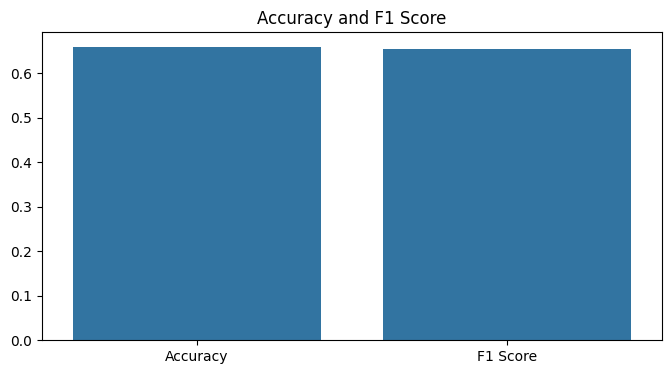

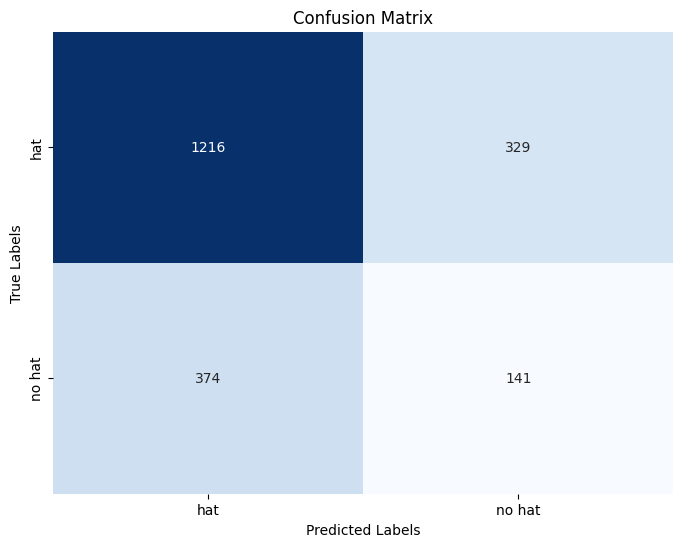

In [24]:
trained_classifier, training_history = imageclassifier.train_classifier(num_epochs=1)

In [36]:
image_path='../../hard_hats/images/test/001135.jpg'
img = image.load_img(image_path, target_size=(224, 224))
img = image.img_to_array(img)
img = preprocess_input(img)
img = np.expand_dims(img, axis=0)

In [37]:
predictions = trained_classifier.predict(img)
class_names = ['Hard Hat', 'No Hard Hat'] 
class_names[int(predictions[0, 0] > 0.5)]

1/1 [==============================] - 0s 180ms/step


'No Hard Hat'

In [56]:
predicted_class = class_names[int(predictions[0, 0] > 0.5)]

In [29]:
predicted_class

'Hard Hat'

In [32]:
predictions[0, 0]

2.0837906e-06

In [33]:
2.0837906e-06 > 1

False

In [56]:
    try:

        shutil.rmtree("../hard_hats/validation/.ipynb_checkpoints")
    except FileNotFoundError:
        print("ipynb_checkpoints FileNotFound")

In [115]:
dataset = tf.data.Dataset.range(100).batch(32)

In [116]:
dataset

<BatchDataset element_spec=TensorSpec(shape=(None,), dtype=tf.int64, name=None)>

In [117]:
taken_batches = dataset.take(3)

In [123]:
g =taken_batches.unbatch().take(3)

In [124]:
for i in g:
    print(i)

tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)


In [ ]:
g